In [1]:
import boto3
import botocore
from iterdub import iterdub as ib
from iterpop import iterpop as ip
import itertools as it
from matplotlib import pyplot as plt
import pandas as pd
from pandas.util import hash_pandas_object
import seaborn as sns
from teeplot import teeplot as tp

In [2]:
from dishpylib.pyhelpers import make_outattr_metadata
from dishpylib.pyhelpers import print_runtime

In [3]:
print_runtime()

context: ci
hostname: 29023d447328
interpreter: 3.8.11 (default, Jul  3 2021, 17:53:42)  [GCC 7.5.0]
notebook name: None
notebook path: None
revision: 363f184c6
timestamp: 2021-07-28T02:56:19Z00:00

IPython==7.16.1
boto3==1.14.44
botocore==1.17.44
iterdub==0.2.0
iterpop==0.3.4
matplotlib==3.3.2
pandas==1.1.2
seaborn==0.11.0
teeplot==0.1.1


# get data

In [4]:
s3_handle = boto3.resource(
    's3',
    region_name="us-east-2",
    config=botocore.config.Config(
        signature_version=botocore.UNSIGNED,
    ),
)
bucket_handle = s3_handle.Bucket('prq49')

series_profiles, = bucket_handle.objects.filter(
    Prefix=f'endeavor=16/thread-profiles/stage=8+what=elaborated/',
)

In [5]:
df = pd.read_csv(
    f's3://prq49/{series_profiles.key}',
    compression='xz',
)
dfdigest = '{:x}'.format(hash_pandas_object( df ).sum())
dfdigest

'-5b38a7939674d585'

In [6]:
for stint in df['Stint'].unique():
    exec(f'df{stint} = df[ df["Stint"] == {stint} ]')

In [7]:
df['Normalized Elapsed Updates'] = df['Update'] / df.groupby([
    'Series',
    'Stint',
])['Update'].transform('mean')

df['Elapsed Update Std'] = df.groupby([
    'Series',
    'Stint',
])['Update'].transform('std') / df.groupby([
    'Series',
    'Stint',
])['Update'].transform('mean')

df['Elapsed Update Span'] = (df.groupby([
    'Series',
    'Stint',
])['Update'].transform('max') - df.groupby([
    'Series',
    'Stint',
])['Update'].transform('min')) / df.groupby([
    'Series',
    'Stint',
])['Update'].transform('mean')

# case study series 16005

In [8]:
dfx = df[ df['Series'] == 16005 ]

teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=lineplot+x=stint+y=elapsed-update-std+ext=.pdf
teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=lineplot+x=stint+y=elapsed-update-std+ext=.png


<AxesSubplot:xlabel='Stint', ylabel='Elapsed Update Std'>

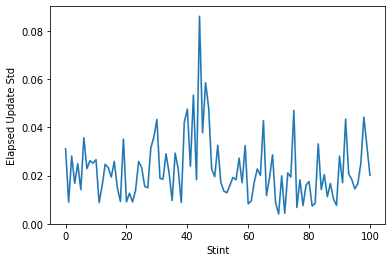

In [9]:
tp.tee(
    sns.lineplot,
    data=dfx,
    x='Stint',
    y='Elapsed Update Std',
    teeplot_outattrs={
        **{
            'bucket' : ib.dub( df['Bucket'] ),
            'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
            'transform' : 'filter-Series-16005',
            '_dfdigest' : dfdigest,
        },
        **make_outattr_metadata()
    },
)

teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=lineplot+x=stint+y=elapsed-update-span+ext=.pdf
teeplots/bucket=prq49+endeavor=16+transform=filter-Series-16005+viz=lineplot+x=stint+y=elapsed-update-span+ext=.png


<AxesSubplot:xlabel='Stint', ylabel='Elapsed Update Span'>

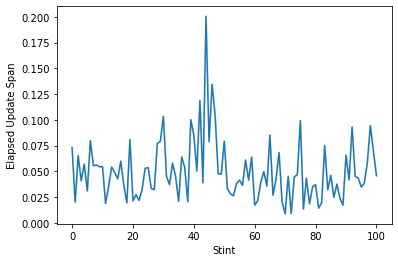

In [10]:
tp.tee(
    sns.lineplot,
    data=dfx,
    x='Stint',
    y='Elapsed Update Span',
    teeplot_outattrs={
        **{
            'bucket' : ib.dub( df['Bucket'] ),
            'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
            'transform' : 'filter-Series-16005',
            '_dfdigest' : dfdigest,
        },
        **make_outattr_metadata()
    },
)

teeplots/bucket=prq49+endeavor=16+hue=stint+transform=filter-Series-16005+viz=boxstrip+x=stint+y=normalized-elapsed-updates+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=stint+transform=filter-Series-16005+viz=boxstrip+x=stint+y=normalized-elapsed-updates+ext=.png


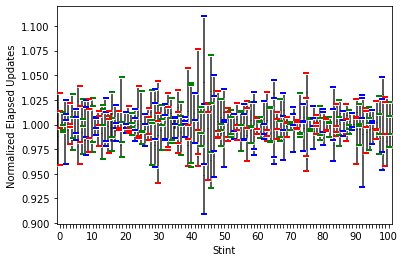

In [11]:
def boxstrip(*args, **kwargs):

    sns.boxplot(
        *args,
        **kwargs,
        whis=(0, 100),
    )
    sns.scatterplot(
        *args,
        **{
            k : v
            for k, v in kwargs.items()
            if k != 'hue'
        },
        marker='_',
        zorder=100,
        linewidth=3,
        color='white',
    )
    sns.scatterplot(
        *args,
        **kwargs,
        marker='_',
        zorder=100,
        linewidth=2,
    )


    plt.gca().get_legend().remove()
    for idx, label in enumerate(plt.gca().xaxis.get_ticklabels()):
        if idx % 10: label.set_visible(False)

tp.tee(
    boxstrip,
    data=dfx,
    x='Stint',
    y='Normalized Elapsed Updates',
    palette=list(it.islice(
        it.cycle(['r','g','b']),
        len(dfx['Stint'].unique())
    )),
    hue='Stint',
    teeplot_outattrs={
        **{
            'bucket' : ib.dub( df['Bucket'] ),
            'endeavor' : ib.dub( df['Endeavor'].astype(int) ),
            'transform' : 'filter-Series-16005',
            '_dfdigest' : dfdigest,
        },
        **make_outattr_metadata()
    },

)

In [12]:
print('mean update std', dfx['Elapsed Update Std'].mean())
print('mean update span', dfx['Elapsed Update Span'].mean())

mean update std 0.022585260791035896
mean update span 0.049990232620249056


In [13]:
max_update_std = dfx['Elapsed Update Std'].max()
print(
    'max update std', max_update_std,
    '@ Stint', ip.pophomogeneous(
        dfx[ dfx['Elapsed Update Std'] == max_update_std ]['Stint']
    )
)

max_update_span = dfx['Elapsed Update Span'].max()
print(
    'max update span', max_update_span,
    '@ Stint', ip.pophomogeneous(
        dfx[ dfx['Elapsed Update Span'] == max_update_span ]['Stint']
    )
)

max update std 0.08621807775514276 @ Stint 44
max update span 0.20057157703299558 @ Stint 44
